In [10]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from scipy.optimize import curve_fit
from lmfit import Model, minimize, Parameters, report_fit
from lmfit.models import GaussianModel, PolynomialModel
import astropy.units as u
import pandas as pd

In [11]:
def Gauss(x, A, B, C):
    #y = A*np.exp(-1*B*x**2)
    y = A*np.exp(-(x-B)**2 / (2.*C**2))
    return y

# Constant "C" definitions, use these to convert to N(OH) and N(HI):
C_1667 = 2.257 * 10e14 * u.cm**-2 / (u.K * u.km/u.s)
C_1665 = 4 * 10e14 * u.cm**-2 / (u.K * u.km/u.s)
C_HI = 1.82 * 10e18 * u.cm**-2 / (u.K * u.km/u.s)

# Constant X(CO) definitions, use to convert W(CO) to N(H2)
Xco = 2 * 10e20 * u.cm**-2 / (u.K * u.km/u.s)

# Abundance ratio, use to convert N(OH) to N(H2)
Xoh = 1e-7

# What is f? The background correction factor?
Tcmb = 2.7
Tex_67 = 5
Tex_65 = 4
f_67 = Tex_67/(Tex_67-Tcmb)
f_65 = Tex_65/(Tex_65-Tcmb)

In [12]:
OH67 = ascii.read('OH119070p2800_67basesub.txt')
OH65 = ascii.read('OH119070p2800_65basesub.txt')
HI = ascii.read('HI119070p2800.txt', data_start = 13, data_end = 167)
CO = ascii.read('CO119070p2800.txt')

In [13]:
#defining vel and Ta for data
vel67 = OH67['col1']
Ta67 = OH67['col2']
vel65 = OH65['col1']
Ta65 = OH65['col2']
velHI = HI['col1']
TaHI = HI['col2']
velCO = CO['col1']
TaCO = CO['col2']

# What is the velocity resolution of each dataset?
deltaV67 = (vel67[1]-vel67[0])
deltaV65 = (vel65[1]-vel65[0])
deltaVCO = (velCO[1]-velCO[0])
deltaVHI = (velHI[1]-velHI[0])

In [14]:
#parameters for OH67:
igood67 = np.where((vel67 >= -30) & (vel67 <= 30))[0]

parameters67, covariance67 = curve_fit(Gauss, vel67[igood67], Ta67[igood67], p0 = [0.03, 0, 4])
fit67A = parameters67[0] # amplitude
fit67B = parameters67[1] # centroid
fit67C = parameters67[2] # sigma
fit_67y = Gauss(vel67, fit67A, fit67B, fit67C)

In [15]:
#parameters for OH65:
igood65 = np.where((vel65 >= -30) & (vel65 <= 30))[0]

parameters65, covariance65 = curve_fit(Gauss, vel65[igood65], Ta65[igood65], p0 = [0.03, 0, 4])
fit65A = parameters65[0]
fit65B = parameters65[1]
fit65C = parameters65[2]
fit_65y = Gauss(vel65, fit65A, fit65B, fit65C)

In [16]:
#parameters for CO:
igoodCO = np.where((velCO >= -25) & (velCO <=25))

parametersCO, covarianceCO = curve_fit(Gauss, velCO[igoodCO], TaCO[igoodCO], p0=[0.03, 0, 4])
fitCOA = parametersCO[0]
fitCOB = parametersCO[1]
fitCOC = parametersCO[2]
fit_COy = Gauss(velCO, fitCOA, fitCOB, fitCOC)

In [17]:
#parameters for HI:
igoodHI = np.where((velHI >= -25) & (velHI <= 25))

parametersHI, covarianceHI = curve_fit(Gauss, velHI[igoodHI], TaHI[igoodHI], p0=[0.03, 0, 4])
fitHIA = parametersHI[0]
fitHIB = parametersHI[1]
fitHIC = parametersHI[2]
fit_HIy = Gauss(velHI, fitHIA, fitHIB, fitHIC)

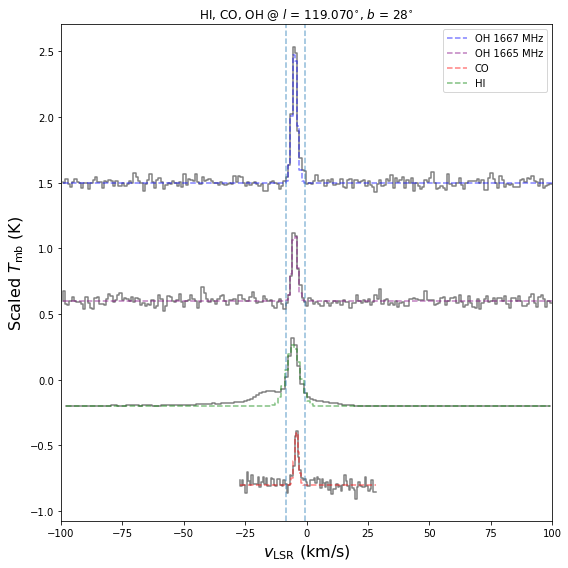

In [19]:
plt.figure(figsize=(8,8))

plt.step(vel67, (Ta67*1.05)*12 + 1.5, 'grey')
plt.step(vel67, fit_67y*12 + 1.5, 'blue', alpha=0.5, ls = 'dashed', label = 'OH 1667 MHz')

plt.step(vel65, (Ta65*1.05)*12+0.6, 'grey')
plt.step(vel65, fit_65y*12+0.6, 'purple', alpha=0.5, ls = 'dashed', label = 'OH 1665 MHz')


plt.step(velCO, TaCO/4-0.8, 'grey')
plt.step(velCO, fit_COy/4-0.8, 'red', alpha=0.5, ls = 'dashed', label = 'CO')

plt.step(velHI, TaHI/60-0.2, 'grey')
plt.step(velHI, fit_HIy/60 -0.2, 'green', alpha=0.5, ls = 'dashed', label = 'HI')

plt.xlim(-100, 100)
#plt.ylim(-1.2, 2)
#plt.axhline(0.6)
#plt.axhline(-0.9)
#plt.axhline(-0.2)
plt.axvline(fit67B+1.5*2.355*fit67C, ls='dashed', alpha=0.5)
plt.axvline(fit67B-1.5*2.355*fit67C, ls='dashed', alpha=0.5)
plt.xlabel(r'$v_{\mathrm{LSR}}$ (km/s)', size=16)
plt.ylabel(r'Scaled $T_{\mathrm{mb}}$ (K)', size=16)
plt.title(r'HI, CO, OH @ $l$ = 119.070$^{\circ}$, $b$ = 28$^{\circ}$')
plt.legend()
plt.tight_layout()

In [20]:
# OH67 noise per channel:
igoodNoise67 = np.where((vel67 >= -150) & (vel67 <= -30))[0]

# Create an igood for the +/- FWHM (where FWHM = 2.355*sigma (b)), for each fit:
igoodOH67 = np.where((vel67 >= fit67B-(1.5*2.355*fit67C)) & (vel67 <= fit67B+(1.5*2.355*fit67C)))[0]
print("Channels in the integral: " + str(len(igoodOH67)))

integralOH67 = np.sum(Ta67[igoodOH67]) * deltaV67
err = np.sqrt(len(vel67[igoodOH67])) * np.std(Ta67[igoodNoise67]) * deltaV67

# Calculate the column density:
NOH_67 = integralOH67 * C_1667 * f_67
NOH_67_err = err * C_1667 * f_67

# Convert N(OH) to N(H2):
NH2_oh67 = NOH_67 / Xoh
NH2_oh67_err = NOH_67_err / Xoh

print(integralOH67)
print(err)
print(integralOH67/err)
print(NOH_67)
print(NOH_67_err)
print(NH2_oh67)
print(NH2_oh67_err)

Channels in the integral: 8
0.2499487809721224
0.005565315034758402
44.91188358809107
1226379127508870.2 s / (cm2 K km)
27306339203151.56 s / (cm2 K km)
1.2263791275088703e+22 s / (cm2 K km)
2.730633920315156e+20 s / (cm2 K km)


In [21]:
# OH65 noise per channel:
igoodNoise65 = np.where((vel65 >= -150) & (vel65 <= -30))[0]

# Create an igood for the +/- FWHM (where FWHM = 2.355*sigma (b)), for each fit:
igoodOH65 = np.where((vel65 >= fit65B-(1.5*2.355*fit65C)) & (vel65 <= fit65B+(1.5*2.355*fit65C)))[0]
print("Channels in the integral: " + str(len(igoodOH65)))

# Perform the integral and calculate the error:
integralOH65 = np.sum(Ta65[igoodOH65]) * deltaV65
err65 = np.sqrt(len(vel65[igoodOH65])) * np.std(Ta65[igoodNoise65]) * deltaV65

# Calculate the column density:
NOH_65 = integralOH65 * C_1665 * f_65
NOH_65_err = err * C_1665 * f_65

# Convert N(OH) to N(H2):
NH2_oh65 = NOH_65 / Xoh
NH2_oh65_err = NOH_65_err / Xoh

print(integralOH65)
print(err65)
print(integralOH65/err)
print(NOH_65)
print(NOH_65_err)
print(NH2_oh65)
print(NH2_oh65_err)

Channels in the integral: 8
0.11940517542727228
0.007064877376388537
21.455241020772835
1469602159104890.0 s / (cm2 K km)
68496185043180.35 s / (cm2 K km)
1.46960215910489e+22 s / (cm2 K km)
6.849618504318035e+20 s / (cm2 K km)


In [22]:
# CO noise per channel:
igoodNoiseCO = np.where((velCO >= 5) & (velCO <=30))

# Create an igood for the +/- FWHM (where FWHM = 1.5*2.355*sigma (b)), for each fit:
igoodCO = np.where((velCO >= fitCOB-(1.5*2.355*fitCOC)) & (velCO <= fitCOB+(1.5*2.355*fitCOC)))[0]
print("Channels in the integral: " + str(len(igoodCO)))

integralCO = np.sum(TaCO[igoodCO]) * deltaVCO
errCO = np.sqrt(len(velCO[igoodCO])) * np.std(TaCO[igoodNoiseCO]) * deltaVCO

# Calculate N(H2) from CO integral (W(CO)):
NH2_CO = integralCO*Xco
NH2_CO_err = errCO*Xco

print(integralCO)
print(errCO)
print(integralCO/err)
print(NH2_CO)
print(NH2_CO_err)

Channels in the integral: 10
3.8220470767388552
0.31769113514469627
686.7620346499891
7.644094153477711e+21 s / (cm2 K km)
6.353822702893926e+20 s / (cm2 K km)


In [23]:
# HI noise per channel:
igoodNoiseHI = np.where((velHI >= 50) & (velHI <=100))

# Create an igood for the +/- FWHM (where FWHM = 1.5*2.355*sigma (b)), for each fit:
igoodHI = np.where((velHI >= fitHIB-(1.5*2.355*fitHIC)) & (velHI <= fitHIB+(1.5*2.355*fitHIC)))[0]
print("Channels in the integral: " + str(len(igoodHI)))

integralHI = np.sum(TaHI[igoodHI]) * deltaVHI
errHI = np.sqrt(len(velHI[igoodHI])) * np.std(TaHI[igoodNoiseHI]) * deltaVHI

# Calculate N(HI) from HI integral (W(HI)):
NHI = integralHI * C_HI
NHI_err = errHI * C_HI

print(integralHI)
print(errHI)
print(integralHI/err)
print(NHI)
print(NHI_err)

Channels in the integral: 15
223.29856000000024
0.34453412082151846
40123.25602510908
4.064033792000004e+21 s / (cm2 K km)
6.270520998951636e+18 s / (cm2 K km)


Text(0.5, 1.0, 'Gas Tracers for $l$= 119.07$^{\\circ}$, $b$=28$^{\\circ}$')

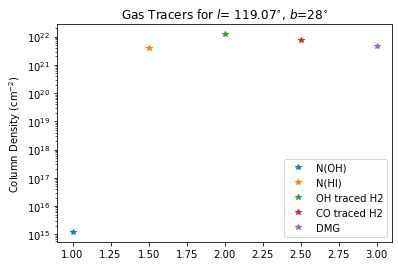

In [24]:
plt.semilogy(1, NOH_67, ls='', marker='*', label='N(OH)')
plt.semilogy(1.5, NHI, ls='', marker='*', label='N(HI)')
plt.semilogy(2, NH2_oh67, ls='', marker='*', label='OH traced H2')
plt.semilogy(2.5, NH2_CO, ls='', marker='*', label='CO traced H2')
plt.semilogy(3, (NH2_oh67-NH2_CO), ls='', marker='*', label='DMG')
plt.ylabel(r"Column Density (cm$^{-2}$)")
plt.legend()
plt.title(r"Gas Tracers for $l$= 119.07$^{\circ}$, $b$=28$^{\circ}$")

In [25]:
### Psuedo code for writing a loop over coordinates:

In [26]:
# Setup a pandas dataframe to save all the variables we'd like
# eventually plot.

resultsTable = pd.DataFrame(np.array([[0, 
                                     0, 
                                     0, 
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0, 
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0, 
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0]]),
                           columns=['l (deg)', 
                                    'b (deg)', 
                                    'T_peak (K)', 
                                    'v_lsr (km/s)',
                                   'FWHMS (km/s)',
                                   'W(OH)_67 (K km/s)',
                                   'sigma W(OH)_67 (K km/s)',
                                   'N(OH)_67 (cm^-2)',
                                   '\sigma N(OH)_67 (cm^-2)',
                                   'N(H2)_OH_67 (cm^-2)',
                                   '\sigma N(H2)_OH_67 (cm^-2)',
                                   'T_peak (K)',
                                   'v_lsr (km/s)',
                                   'FWHM (km/s)',
                                   'W(OH)_65 (K km/s)',
                                   '\sigma W(OH)_65 (K km/s)',
                                   'N(OH)_65 (cm^-2)',
                                   '\sigma N(OH)_65 (cm^-2)',
                                   'N(H2)_{OH_65} (cm^-2)',
                                   '\sigma N(H2)_OH_65 (cm^-2)',
                                   'T_peak (K)',
                                   'v_lsr (km/s)',
                                   'FWHM (km/s)',
                                   'W(HI) (K km/s)',
                                   '\sigma W(HI) (K km/s)',
                                   'N(HI) (cm^-2)',
                                   '\sigma N(HI) (cm^-2)',
                                   'T_peak (K)',
                                   'v_lsr (km/s)',
                                   'FWHM (km/s)',
                                   'W(CO) (K km/s)',
                                   '\sigma W(CO) (K km/s)',
                                   'N(H2)_{CO} (cm^-2)',
                                   '\sigma N(H2)_CO (cm^-2)',
                                   ])

In [27]:
# Setup constants for column densities, read e.g. Busch 2019, Busch 2021:

# Constant "C" definitions, use these to convert to N(OH) and N(HI):
C_1667 = 2.257 * 10e14 * u.cm**-2 / (u.K * u.km/u.s)
C_1665 = 4 * 10e14 * u.cm**-2 / (u.K * u.km/u.s)
C_HI = 1.82 * 10e18 * u.cm**-2 / (u.K * u.km/u.s)

# Constant X(CO) definitions, use to convert W(CO) to N(H2)
Xco = 2 * 10e20 * u.cm**-2 / (u.K * u.km/u.s)

# Abundance ratio of OH/H2, used to convert N(OH) to N(H2)
Xoh = 1e-7

# What is f? The background correction factor? The contrast between Tcmb and Tex? It is slightly different for 1667 and 1665.
Tcmb = 2.7
Tex_67 = 5
Tex_65 = 4
f_67 = Tex_67/(Tex_67-Tcmb)
f_65 = Tex_65/(Tex_65-Tcmb)

# Put all coordinates in a list of tuples:
# lb = [(119.07, 28), (), (), (), etc...]
lb = [(119.07, 28)]

for coords in lb:
    # Read the longitude of the pointing:
    l = coords[0]
    l = str(int(l*1000))
    
    # Read the latitude of the pointing:
    b = coords[1]
    b = str(int(b*100))
    
    # load data, multiply coordinates by 1000 and 100 
    # and force them to be integer then strings, 
    # then load them using string concatenation:
    OH67 = ascii.read('OH' + l + 'p' + b + '_67basesub.txt')
    OH65 = ascii.read('OH' + l + 'p' + b + '_65basesub.txt')
    HI = ascii.read('HI' + l + 'p' + b + '.txt', data_start = 13, data_end = 167)
    CO = ascii.read('CO' + l + 'p' + b + '.txt')
    
    # All the data is now loaded, now we define our velocity and temperatures like this:
    vel67 = OH67['col1']
    Ta67 = OH67['col2']
    vel65 = OH65['col1']
    Ta65 = OH65['col2']
    velH = HI['col1']
    TaH = HI['col2']
    velCO = CO['col1']
    TaCO = CO['col2']
    
    # Setup indicies for std calculation of spectra:
    igoodNoise67 = np.where((vel67 >= -150) & (vel67 <= -30))[0]
    igoodNoise65 = np.where((vel65 >= -150) & (vel65 <= -30))[0]
    igoodNoiseCO = np.where((velCO >= 5) & (velCO <= 30))
    igoodNoiseHI = np.where((velHI >= 50) & (velHI <= 100))
    
    # Setup indicies for Gaussian fitting:
    igood67 = np.where((vel67 >= -25) & (vel67 <= 25))[0]
    igood65 = np.where((vel65 >= -25) & (vel65 <= 25))[0]
    igoodCO = np.where((velCO >= -25) & (velCO <= 25))
    igoodHI = np.where((velHI >= -25) & (velHI <= 25))
    
    # Perform Gaussian fitting of 1667:
    parameters67, covariance67 = curve_fit(Gauss, vel67[igood67], Ta67[igood67], p0 = [0.03, 0, 4])
    fit67A = parameters67[0] # amplitude
    fit67B = parameters67[1] # centroid
    fit67C = parameters67[2] # sigma
    fit_67y = Gauss(vel67, fit67A, fit67B, fit67C)
    
    # Perform Gaussian fitting of 1665:
    parameters65, covariance65 = curve_fit(Gauss, vel65[igood65], Ta65[igood65], p0 = [0.03, 0, 4])
    fit65A = parameters65[0]
    fit65B = parameters65[1]
    fit65C = parameters65[2]
    fit_65y = Gauss(vel65, fit65A, fit65B, fit65C)
    
    # Perform Gaussian fitting of CO:
    parametersCO, covarianceCO = curve_fit(Gauss, velCO[igoodCO], TaCO[igoodCO], p0=[0.03, 0, 4])
    fitCOA = parametersCO[0]
    fitCOB = parametersCO[1]
    fitCOC = parametersCO[2]
    fit_COy = Gauss(velCO, fitCOA, fitCOB, fitCOC)
    
    # Perform Gaussian fitting of HI:
    parametersHI, covarianceHI = curve_fit(Gauss, velHI[igoodHI], TaHI[igoodHI], p0=[0.03, 0, 4])
    fitHIA = parametersHI[0]
    fitHIB = parametersHI[1]
    fitHIC = parametersHI[2]
    fit_HIy = Gauss(velHI, fitHIA, fitHIB, fitHIC)
    
    # Calculate integrated flux, column densities for OH 1667:
    # Create an igood for the +/- FWHM (where FWHM = 2.355*sigma (b)), for each fit:
    igoodOH67 = np.where((vel67 >= fit67B-(1.5*2.355*fit67C)) & (vel67 <= fit67B+(1.5*2.355*fit67C)))[0]
    integralOH67 = np.sum(Ta67[igoodOH67]) * deltaV67
    err67 = np.sqrt(len(vel67[igoodOH67])) * np.std(Ta67[igoodNoise67]) * deltaV67
    # Calculate the column density from W(OH_1667):
    NOH_67 = integralOH67 * C_1667 * f_67
    NOH_67_err = err67 * C_1667 * f_67
    # Convert N(OH) to N(H2):
    NH2_oh67 = NOH_67 / Xoh
    NH2_oh67_err = NOH_67_err / Xoh
    
    # Calculate integrated flux, column densities for OH 1665:
    # Create an igood for the +/- FWHM (where FWHM = 2.355*sigma (b)), for each fit:
    igoodOH65 = np.where((vel65 >= fit65B-(1.5*2.355*fit65C)) & (vel65 <= fit65B+(1.5*2.355*fit65C)))[0]
    # Perform the integral and calculate the error:
    integralOH65 = np.sum(Ta65[igoodOH65]) * deltaV65
    err65 = np.sqrt(len(vel65[igoodOH65])) * np.std(Ta65[igoodNoise65]) * deltaV65
    # Calculate the column density from W(OH_1665):
    NOH_65 = integralOH65 * C_1665 * f_65
    NOH_65_err = err * C_1665 * f_65
    # Convert N(OH) to N(H2):
    NH2_oh65 = NOH_65 / Xoh
    NH2_oh65_err = NOH_65_err / Xoh
    
    # Calculate integrated flux, CO-traced H2 column density:
    # Create an igood for the +/- FWHM (where FWHM = 1.5*2.355*sigma (b)), for each fit:
    igoodCO = np.where((velCO >= fitCOB-(1.5*2.355*fitCOC)) & (velCO <= fitCOB+(1.5*2.355*fitCOC)))[0]
    integralCO = np.sum(TaCO[igoodCO]) * deltaVCO
    errCO = np.sqrt(len(velCO[igoodCO])) * np.std(TaCO[igoodNoiseCO]) * deltaVCO
    # Calculate N(H2) from CO integral (W(CO)):
    NH2_CO = integralCO*Xco
    NH2_CO_err = errCO*Xco
    
    # Calculate integrated flux, and calculate HI column density:
    # Create an igood for the +/- FWHM (where FWHM = 1.5*2.355*sigma (b)), for each fit:
    igoodHI = np.where((velHI >= fitHIB-(1.5*2.355*fitHIC)) & (velHI <= fitHIB+(1.5*2.355*fitHIC)))[0]
    integralHI = np.sum(TaHI[igoodHI]) * deltaVHI
    errHI = np.sqrt(len(velHI[igoodHI])) * np.std(TaHI[igoodNoiseHI]) * deltaVHI
    # Calculate N(HI) from HI integral (W(HI)):
    NHI = integralHI * C_HI
    NHI_err = errHI * C_HI
    
    # Add a row to the resultsTable of the variables we just calculated:
    resultsTable.loc[len(resultsTable.index)] = [coords[0], 
                                     coords[1], 
                                     fit67A, 
                                     fit67B,
                                     2.355*fit67C,
                                     integralOH67,
                                     err67,
                                     NOH_67.value,
                                     NOH_67_err.value,
                                     NH2_oh67.value,
                                     NH2_oh67_err.value,
                                     fit65A,
                                     fit65B,
                                     2.355*fit65C,
                                     integralOH65,
                                     err65,
                                     NOH_65.value,
                                     NOH_65_err.value,
                                     NH2_oh65.value,
                                     NH2_oh65_err.value,
                                     fitHIA, 
                                     fitHIB,
                                     2.355*fitHIC,
                                     integralHI,
                                     errHI,
                                     NHI.value,
                                     NHI_err.value,
                                     fitCOA, 
                                     fitCOB,
                                     2.355*fitCOC,
                                     integralCO,
                                     errCO,
                                     NH2_CO.value,
                                     NH2_CO_err.value]

In [317]:
'''
resultsTable = pd.DataFrame(np.array([[int(l)/1000, 
                                     int(b)/100, 
                                     fit67A, 
                                     fit67B,
                                     2.355*fit67C,
                                     integralOH67,
                                     err67,
                                     NOH_67.value,
                                     NOH_67_err.value,
                                     NH2_oh67.value,
                                     NH2_oh67_err.value,
                                     fit65A,
                                     fit65B,
                                     2.355*fit65C,
                                     integralOH65,
                                     err65,
                                     NOH_65.value,
                                     NOH_65_err.value,
                                     NH2_oh65.value,
                                     NH2_oh65_err.value,
                                     fitHIA, 
                                     fitHIB,
                                     2.355*fitHIC,
                                     integralHI,
                                     errHI,
                                     NHI.value,
                                     NHI_err.value,
                                     fitCOA, 
                                     fitCOB,
                                     2.355*fitCOC,
                                     integralCO,
                                     errCO,
                                     NH2_CO.value,
                                     NH2_CO_err.value]]),
                           columns=['l (deg)', 
                                    'b (deg)', 
                                    'T_peak (K)', 
                                    'v_lsr (km/s)',
                                   'FWHMS (km/s)',
                                   'W(OH)_67 (K km/s)',
                                   'sigma W(OH)_67 (K km/s)',
                                   'N(OH)_67 (cm^-2)',
                                   '\sigma N(OH)_67 (cm^-2)',
                                   'N(H2)_OH_67 (cm^-2)',
                                   '\sigma N(H2)_OH_67 (cm^-2)',
                                   'T_peak (K)',
                                   'v_lsr (km/s)',
                                   'FWHM (km/s)',
                                   'W(OH)_65 (K km/s)',
                                   '\sigma W(OH)_65 (K km/s)',
                                   'N(OH)_65 (cm^-2)',
                                   '\sigma N(OH)_65 (cm^-2)',
                                   'N(H2)_{OH_65} (cm^-2)',
                                   '\sigma N(H2)_OH_65 (cm^-2)',
                                   'T_peak (K)',
                                   'v_lsr (km/s)',
                                   'FWHM (km/s)',
                                   'W(HI) (K km/s)',
                                   '\sigma W(HI) (K km/s)',
                                   'N(HI) (cm^-2)',
                                   '\sigma N(HI) (cm^-2)',
                                   'T_peak (K)',
                                   'v_lsr (km/s)',
                                   'FWHM (km/s)',
                                   'W(CO) (K km/s)',
                                   '\sigma W(CO) (K km/s)',
                                   'N(H2)_{CO} (cm^-2)',
                                   '\sigma N(H2)_CO (cm^-2)',
                                   ])
'''

"\nresultsTable = pd.DataFrame(np.array([[int(l)/1000, \n                                     int(b)/100, \n                                     fit67A, \n                                     fit67B,\n                                     2.355*fit67C,\n                                     integralOH67,\n                                     err67,\n                                     NOH_67.value,\n                                     NOH_67_err.value,\n                                     NH2_oh67.value,\n                                     NH2_oh67_err.value,\n                                     fit65A,\n                                     fit65B,\n                                     2.355*fit65C,\n                                     integralOH65,\n                                     err65,\n                                     NOH_65.value,\n                                     NOH_65_err.value,\n                                     NH2_oh65.value,\n                           